## Historical Simulation

이번 장에서는 전략을 수립하고 실제 전략의 가치평가를 하는 방법에 대해 알아본다. 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
data = yf.download(
    ['SPY'],
    start = '2010-01-01',
    end = '2025-02-22',
    interval = '1d', # 데이터 추출 빈도 (기본값 : 1일)
    progress = False, # 다운로드 시 progress bar 표시 여부
    auto_adjust = True, 
    multi_level_index = False # Multi Index형태의 컬럼 지정 해제
)

### 1. Strategy

전략에는 다양한 종류가 존재한다. 기업의 재무데이터를 기반으로 전략을 구성할 수도 있고, Technical Indicator를 기반으로 전략을 구성할 수도 있다. 대표적인 전략은 다음과 같다.

- 고평가 기업 매도, 저평가 기업 매수 전략 : PBR 혹은 PER을 이용해, 산업(주로 섹터) 평균에 비해 높은 기업을 매도, 낮은 기업을 매수
- 기술적 지표 기반 매매 전략 : 기술적 지표를 기반으로 단일 자산에 대해 매도 신호가 나오면 매도, 매수신호가 나오면 매수
- Pairs Trading : 주가의 흐름이 비슷한 종목 두 개를 이용해 상대적 저평가된 종목을 매수, 고평가된 종목을 매도
- 정보 전달 속도 기반 매매 전략 : 고성능 컴퓨팅을 이용해 동일 전략을 수행하더라도, 의사결정을 더 빨리 수행해 차익을 내는 전략

여기서는 간단하게 이동평균 매매를 통해 전략을 수행해본다.

#### 1.1 Moving Average 계산

`pandas`의 `rolling()` method를 사용하여 가격의 이동평균을 구할 수 있다. 

In [3]:
ma20_price = data['Close'].rolling(20).mean() # 20일 이동평균가격
ma60_price = data['Close'].rolling(60).mean() # 60일 이동평균가격

참고 : 이동평균선의 분류

- 5일선 : 심리선
- 20일선 : 생명선 혹은 세력선
- 60일선 : 수급선
- 120일선 : 경기선
- 250일선 : 대세선

20일선(1개월)과 60일선(3개월)의 교차를 주요 시그널로 판단하며, 단기 이동평균선이 장기 이동평균선 위에 존재할 경우를 정배열, 그 반대를 역배열이라고 한다.

단기 이동평균선이 장기 이동평균을 상향 돌파하는 경우 **골든크로스**라고 부르고 매수신호로 해석하며, 하향 돌파하는 경우를 **데드크로스**라고 하며 매도 신호로 해석한다.

In [4]:
buy_signal = (ma20_price >= ma60_price) & (ma20_price.shift(1) < ma60_price.shift(1)) # 상향돌파
sell_signal = (ma20_price < ma60_price) & (ma20_price.shift(1) >= ma60_price.shift(1)) # 하향돌파

In [5]:
data[buy_signal].index # 매수 신호가 발생한 날짜

DatetimeIndex(['2010-08-03', '2010-09-15', '2011-07-21', '2011-10-24',
               '2012-07-11', '2012-12-20', '2013-09-17', '2014-02-28',
               '2014-08-28', '2014-11-12', '2015-02-17', '2015-08-05',
               '2015-10-26', '2016-03-11', '2016-11-23', '2018-03-14',
               '2018-05-21', '2019-02-04', '2019-06-27', '2019-09-18',
               '2020-05-06', '2020-10-08', '2021-10-28', '2022-04-05',
               '2022-08-02', '2022-11-16', '2023-01-26', '2023-04-12',
               '2023-11-22', '2024-05-17', '2024-08-30', '2025-01-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [6]:
data[sell_signal].index # 매도 신호가 발생한 날짜

DatetimeIndex(['2010-05-20', '2010-09-01', '2011-06-09', '2011-08-05',
               '2012-05-11', '2012-11-07', '2013-09-11', '2014-02-10',
               '2014-08-20', '2014-10-13', '2015-01-27', '2015-06-30',
               '2015-08-19', '2015-12-30', '2016-09-27', '2018-02-27',
               '2018-03-20', '2018-10-19', '2019-05-31', '2019-08-22',
               '2020-03-05', '2020-10-07', '2021-10-04', '2022-01-25',
               '2022-04-29', '2022-09-20', '2023-01-10', '2023-03-17',
               '2023-09-05', '2024-05-01', '2024-08-13', '2025-01-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

매수 신호를 기반으로 이동평균 전략을 생성하자. 실제 투자는 신호가 발생한 뒤 진입해야 하므로, 그 다음날 종가를 기준으로 진입한다고 가정한다.

<Axes: xlabel='Date'>

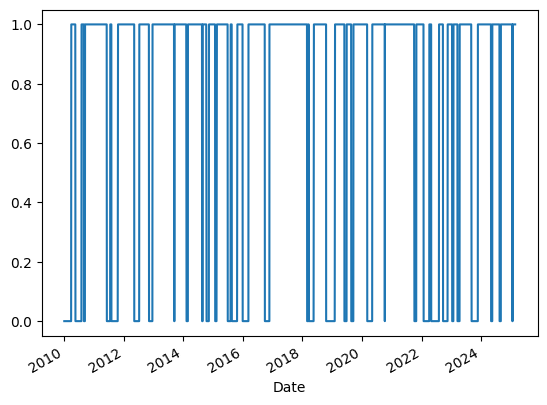

In [9]:
(ma20_price >= ma60_price).astype(int).plot()

In [10]:
position = (ma20_price >= ma60_price).astype(int)

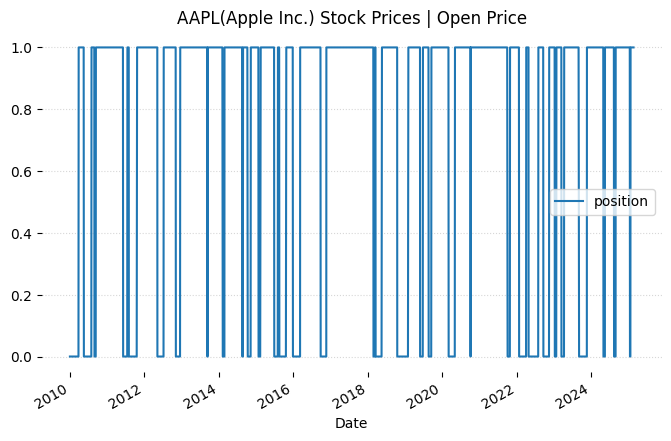

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
position.plot(ax = ax, label = 'position')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'AAPL(Apple Inc.) Stock Prices | Open Price')
plt.show()

In [12]:
ret = data['Close'].pct_change() # 수익률
strategy_ret = ret * position.shift(1)

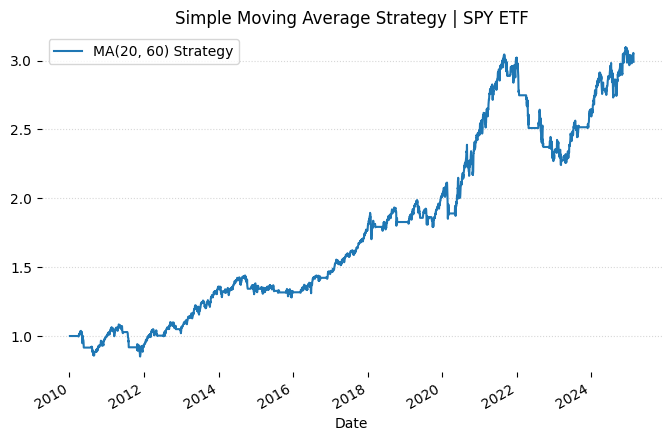

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
(1 + strategy_ret).cumprod().plot(ax = ax, label = 'MA(20, 60) Strategy')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Simple Moving Average Strategy | SPY ETF')
plt.show()


신호를 미루지 않으면 다음과 같은 실수를 범할 수 있다. 실제 전략 성과보다 과대 추정되는 오류를 범할 수 있다.

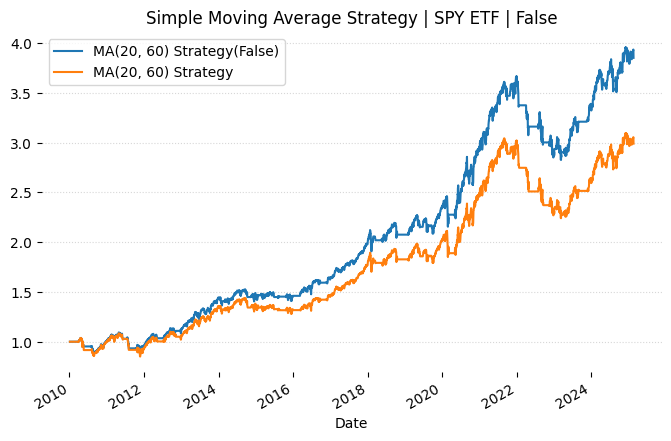

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
(1 + ret * position).cumprod().plot(ax = ax, label = 'MA(20, 60) Strategy(False)')
(1 + strategy_ret).cumprod().plot(ax = ax, label = 'MA(20, 60) Strategy')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Simple Moving Average Strategy | SPY ETF | False')
plt.show()

### 2. Historical Backtesting

과거 데이터를 기반으로 백테스팅을 할 때에는 다음과 같은 제약조건을 생각해야 한다.

- 거래 비용 (매수와 매도시 수수료를 고려하였는가?)
- 유동성 제약 (거래량은 충분한가?)
- 주문가 위험 (주문 시 가격을 원하는 위치에서 매수를 할 수 있는가?)

대개 거래비용은 매수와 매도 양쪽에서 각각 15bp(0.15%)를 고려하며, 유동성 제약을 지키기 위해 대형주 위주로 전략을 생성하는 것이 일반적이다.

#### 2.1 거래비용

거래비용은 매수와 매도 각각 15bp를 지정하는 것이 일반적이며, 상황에 따라 30bp를 가정하기도 한다. 이는 거래 환경에 따라 달라지므로 사용자의 하이퍼파라미터와 같다.

In [15]:
buy_fee = buy_signal.astype(int) * 0.0015
sell_fee = sell_signal.astype(int) * 0.0015

In [16]:
trading_cost = (np.abs(strategy_ret) * (buy_fee + sell_fee)).cumsum()

<Axes: xlabel='Date'>

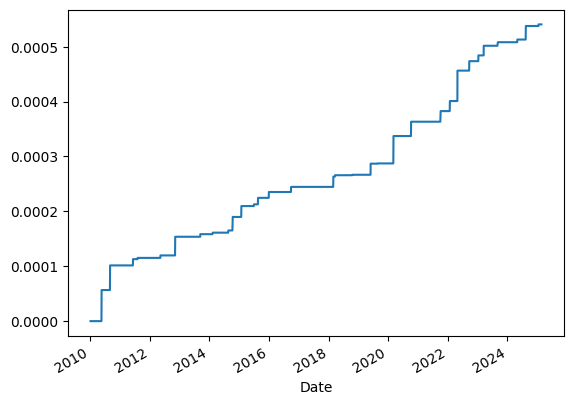

In [18]:
trading_cost.plot()

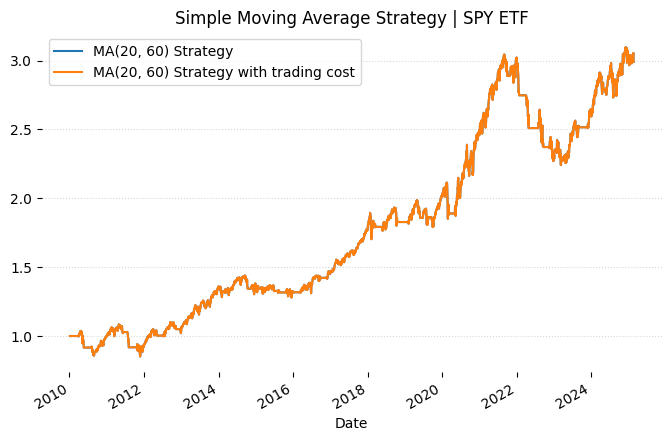

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))

(1 + strategy_ret).cumprod().plot(ax = ax, label = 'MA(20, 60) Strategy')
((1 + strategy_ret).cumprod() - trading_cost).plot(ax = ax, label = 'MA(20, 60) Strategy with trading cost')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Simple Moving Average Strategy | SPY ETF')
plt.show()

좀 더 정교한 방법으로 고가-저가 스프레드를 이용해 유동성 비용을 추정하기도 하는데, 이는 추후 연습문제로 남겨둔다.

In [19]:
final_performance = ((1 + strategy_ret).cumprod() - trading_cost)

#### 2.2 거치식 시뮬레이션 (Lump sum Simulation)

거치식 시뮬레이션은 전략을 그대로 실행하였을 때의 성과를 의미한다. 초기 투자금을 전략의 성과에 곱해 구할 수 있다.

In [20]:
init_investment = 10_000 # 초기 1만달러를 투자한다고 가정

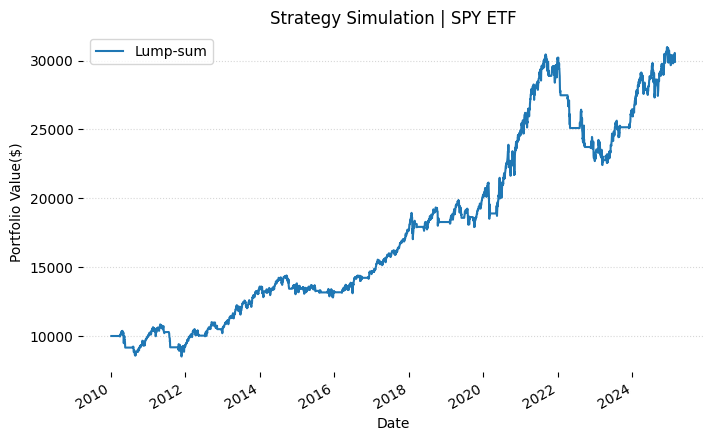

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))

(final_performance * init_investment).plot(ax = ax, label = 'Lump-sum')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Strategy Simulation | SPY ETF')
plt.ylabel('Portfolio Value($)')
plt.show()

#### 2.3 적립식 시뮬레이션(Cost-average Simulation)

적립식 시뮬레이션이란 일정 기간마다 일정 금액을 투자하여 성과를 계산하는 시뮬레이션이다. 대개 연금 상품에 해당되며, 증권사 앱에서 서비스중인 월적립 시뮬레이션도 비슷한 맥락이다. 이 경우, 거치식 시뮬레이션과 비교하기 위해서는 몇 가지 튜닝 과정을 거쳐야 한다.

In [22]:
final_performance.fillna(1, inplace = True)

In [24]:
investment_per_period = 100 # 매월 100달러씩 투자
total_shares = 0  # 총 보유 수량
total_investment = 0  # 총 투자 금액

investment_log = [] # 거래기록
dates = final_performance.index # 날짜 = 퍼포먼스의 날짜
portfolio_prices = final_performance.tolist() 

In [25]:
# edge case : 주간 혹은 일간 데이터일 때, 월간 적립식을 하기 위해서 월초 날짜를 캐치하는 과정

dates_weekly = pd.DataFrame(dates)
dates_weekly['year_month'] = dates_weekly['Date'].dt.to_period('M')
date_month_end = dates_weekly.groupby('year_month').first().reset_index()['Date'] # 월초 날짜

거래 과정은 시간에 따라 흘러가기 때문에, 반복문을 활용해 가상의 거래 기록을 작성한다

In [26]:
for date, price in zip(dates, portfolio_prices):
    shares_bought = 0  # 기본적으로 월초가 아니면 매수하지 않음
    
    if date in list(date_month_end) :
        if date == pd.to_datetime(final_performance.index[-1]) : # 만약 마지막 날일 경우
            current_value = total_shares * price
            profit = current_value - total_investment
            roi = (profit / total_investment) if total_investment > 0 else 0  # 0으로 나누는 것 방지
        
            investment_log.append([date, price, shares_bought, total_shares, total_investment, current_value, roi])
            break
            
        shares_bought = investment_per_period / price  # 해당 월 가격으로 매수 가능 수량
        total_shares += shares_bought
        total_investment += investment_per_period  # 투자금 증가

    # 현재 평가 금액
    current_value = total_shares * price
    profit = current_value - total_investment
    roi = (profit / total_investment) if total_investment > 0 else 0  # 0으로 나누는 것 방지

    investment_log.append([date, price, shares_bought, total_shares, total_investment, current_value, roi])

In [27]:
investment_log

[[Timestamp('2010-01-04 00:00:00'), 1.0, 100.0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-05 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-06 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-07 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-08 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-11 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-12 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-13 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-14 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-15 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-19 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-20 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-21 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-22 00:00:00'), 1.0, 0, 100.0, 100, 100.0, 0.0],
 [Timestamp('2010-01-25 00:00:

In [28]:
cost_average = pd.DataFrame(investment_log)
cost_average.columns = ['Date','Price','Shares_bought','Total','Investment','Current','ROI']
cost_average.set_index('Date',inplace=True)

아래의 장표를 확인하면, 매입가격과 매입시간, 매입 수량, 포트폴리오 가치와 총 투자금을 확인할 수 있다. 

In [29]:
cost_average

,Price,Shares_bought,Total,Investment,Current,ROI
Date,,,,,,
2010-01-04,1.000000,100.0,100.000000,100,100.000000,0.000000
2010-01-05,1.000000,0.0,100.000000,100,100.000000,0.000000
2010-01-06,1.000000,0.0,100.000000,100,100.000000,0.000000
2010-01-07,1.000000,0.0,100.000000,100,100.000000,0.000000
2010-01-08,1.000000,0.0,100.000000,100,100.000000,0.000000
...,...,...,...,...,...,...
2025-02-14,3.039203,0.0,11820.147503,18200,35923.828297,0.973837
2025-02-18,3.048127,0.0,11820.147503,18200,36029.313453,0.979633
2025-02-19,3.055307,0.0,11820.147503,18200,36114.174205,0.984295


포트폴리오의 가치는 다음과 같이 확인 가능하다.

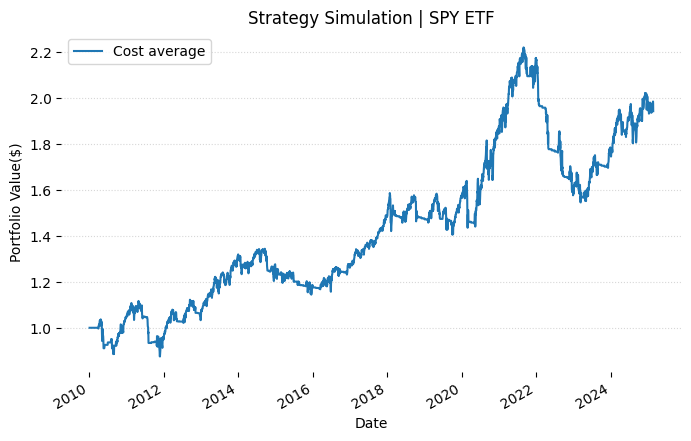

In [30]:
fig, ax = plt.subplots(figsize = (8, 5))

(cost_average['Current'] / cost_average['Investment']).plot(ax = ax, label = 'Cost average')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Strategy Simulation | SPY ETF')
plt.ylabel('Portfolio Value($)')
plt.show()

두 전략의 성과 차이를 비교해 보자. 시장이 줄곧 우상향해왔으므로, 적립식에 비해 거치식 시뮬레이션이 더 우수한 성과를 보인다. 그러나 현실적으로 거치식은 드문 경우이기 때문에, 적립식의 성과가 현실과 더 맞아떨어진다고 볼 수 있다.

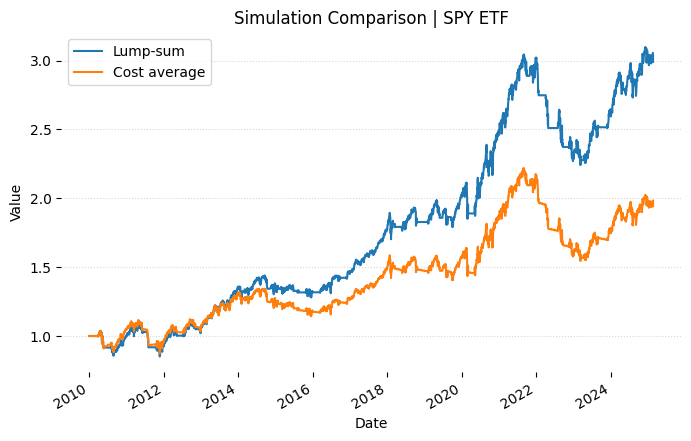

In [31]:
fig, ax = plt.subplots(figsize = (8, 5))

(final_performance).plot(ax = ax, label = 'Lump-sum')
(cost_average['Current'] / cost_average['Investment']).plot(ax = ax, label = 'Cost average')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Simulation Comparison | SPY ETF')
plt.ylabel('Value')
plt.show()

전략의 성과를 좀 더 정교하게 보기 위해서는 시간 가중 수익률로 보아야 하는데, 이 부분에 관해서는 연습문제로 남긴다.

### 3. Backtest Statistics

전략이 얼마만큼의 성과를 냈는지 객관적으로 판단하기 위해서는 다양한 성과 지표를 확인해야 한다. 단순 최종 수익률만을 봐도 되지만, 아래와 같은 지표들이 자주 사용된다.

#### 3.1 위험조정 수익률

위험조정 수익률은 수익률을 표준편차로 나누어 나타낸 지표이다. 투자자가 감수한 리스크 대비 보상을 의미하며, 주로 연율화하여 계산한다.

In [33]:
risk_adj_return = final_performance.pct_change().loc['2020':].mean() / final_performance.pct_change().loc['2020':].std() * np.sqrt(252)
print(f'2020년 이후 위험 조정 수익률 : {risk_adj_return * 100:.2f}%')

2020년 이후 위험 조정 수익률 : 63.37%


대표적인 위험조정 수익률은 Sharpe Ratio가 있는데, 성과에서 무위험수익률을 차감하여 성과의 표준편차로 나눈 값을 사용한다.

$$\text{SR} = \frac{r_i - r_f}{\sigma_i}$$

무위험수익률은 대개 3개월 혹은 2년물의 T-Bond yield rate를 사용한다.

In [36]:
t_bill = yf.download(
    ['^IRX'],
    start = '2010-01-01',
    end = '2025-02-22',
    interval = '1d', 
    progress = False,
    auto_adjust = True, 
    multi_level_index = False 
)

In [37]:
t_bill


,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,0.055,0.080,0.055,0.080,0
2010-01-05,0.060,0.065,0.040,0.060,0
2010-01-06,0.045,0.060,0.045,0.060,0
2010-01-07,0.045,0.055,0.040,0.045,0
2010-01-08,0.040,0.045,0.035,0.045,0
...,...,...,...,...,...
2025-02-14,4.213,4.213,4.203,4.210,0
2025-02-18,4.213,4.218,4.205,4.213,0
2025-02-19,4.218,4.223,4.218,4.220,0


In [38]:
risk_free = t_bill['Close'] / 252 / 100 # 연율화된 값이므로 반드시 나눠서 사용

<Axes: xlabel='Date'>

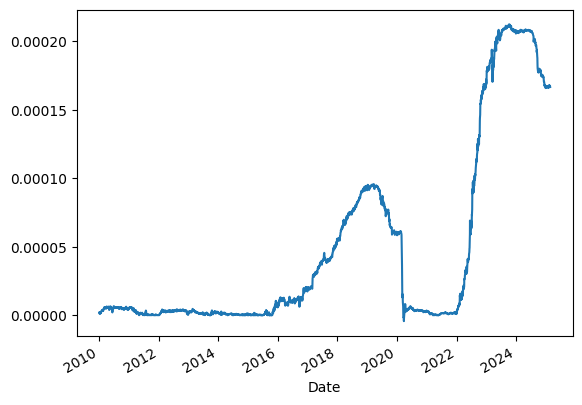

In [41]:
risk_free.plot()

In [42]:
excess_ret = final_performance.pct_change().loc['2020':] - risk_free.loc[final_performance.pct_change().loc['2020':].index]

In [43]:
sharpe_ratio = excess_ret.mean() / final_performance.pct_change().loc['2020':].std() * np.sqrt(252)
print(f'Sharpe ratio: {sharpe_ratio :.2f}')

Sharpe ratio: 0.45


#### 3.2 Track Error

Tracking Error는 벤치마크를 얼마나 Track했는지 보여주는 지표로, 전략의 수익률과 벤치마크의 수익률을 뺀 값의 표준편차로 계산한다.

$$\text{TR} = \sigma(r_i - r_b)$$

이 값이 3을 넘어갈 경우, Active한 전략이라고 한다. 

In [44]:
tracking_error = (final_performance.pct_change().loc['2020':] - data['Close'].pct_change().loc['2020':]).std()

In [45]:
print(f"tracking error: {tracking_error * 100 : .2f}")

tracking error:  0.99


#### 3.3 연간 평균 거래 빈도

연간 평균 거래 빈도는 거래비용과 관련된 통계량이다. 거래가 빈번할수록 주문 실수와 스프레드 위험에 노출되기 때문에, 연평균 거래빈도는 낮을수록 좋은 전략이다. 

매수빈도와 매도빈도의 총합의 백테스트 기간을 나눈 값을 사용한다.

In [46]:
signal_freq = buy_signal.loc['2020':].astype(int).sum() + sell_signal.loc['2020':].astype(int).sum()
backtest_period = len(buy_signal.loc['2020':]) / 252

In [47]:
print(f"Average signal frequency : {signal_freq / backtest_period :.2f}")

Average signal frequency : 4.68


hit-ratio : 상승할때 전략도 상승하면 1, 하락하면 0 

- 전략과 벤치마크의 상관관계 